###Loading data via google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
small_area = '/content/drive/MyDrive/Colab Notebooks/CaseStudy4DSight/Small_area.png'
small_area_rotated = '/content/drive/MyDrive/Colab Notebooks/CaseStudy4DSight/Small_area_rotated.png'
star_map = '/content/drive/MyDrive/Colab Notebooks/CaseStudy4DSight/StarMap.png'

###Allocating directories

In [3]:
import os
template_path = '/content/rotated_templates'
results_path = '/content/results'
masks_path = '/content/results'
try:
  os.mkdir('rotated_templates')
  os.mkdir('masks')
  os.mkdir('results')
except:
  pass

###Template Matching
Here I used a brute force approach to find the rotated image by creating 360 variations of the template and a corresponding mask for each one. 

In [4]:
import sys
import cv2 as cv
import numpy as np
from scipy import misc, ndimage
from matplotlib import pyplot as plt


Choosing the input file

In [5]:
image_path = "small_area" #@param ['small_area', 'small_area_rotated']
image_path = eval(image_path)
template = cv.imread(image_path, 0)
img = cv.imread(star_map, 0)

Creating rotated templates


In [6]:
for deg in range(360):
  rotated_template = ndimage.rotate(template, deg)
  cv.imwrite(os.path.join(template_path, 'template%d.png' %deg), rotated_template)
  

Creating rotated masks

In [7]:
for deg in range(360):
  template = cv.imread(os.path.join(template_path, 'template%d.png' %deg), cv.IMREAD_GRAYSCALE)
  if template is None:
    print('Failed to load template%d.png' %deg)
  else:
    _, mask = cv.threshold(template, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    cv.imwrite(os.path.join(masks_path, 'mask%d.png' %deg), mask)

Adjusting hyperparameters

In [8]:
method_str = "cv.TM_SQDIFF" #@param ['cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED', 'cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED']
degree_interval = 1  #@param {type: "slider", min: 1, max: 90}
threshold =  11#@param {type: "number"}

Matching

method used: cv.TM_SQDIFF
degree interval: 1
threshold: 11
Match for deg0, on (855, 150), (969, 150), (855, 264), (969, 264) with 0.0


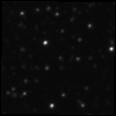

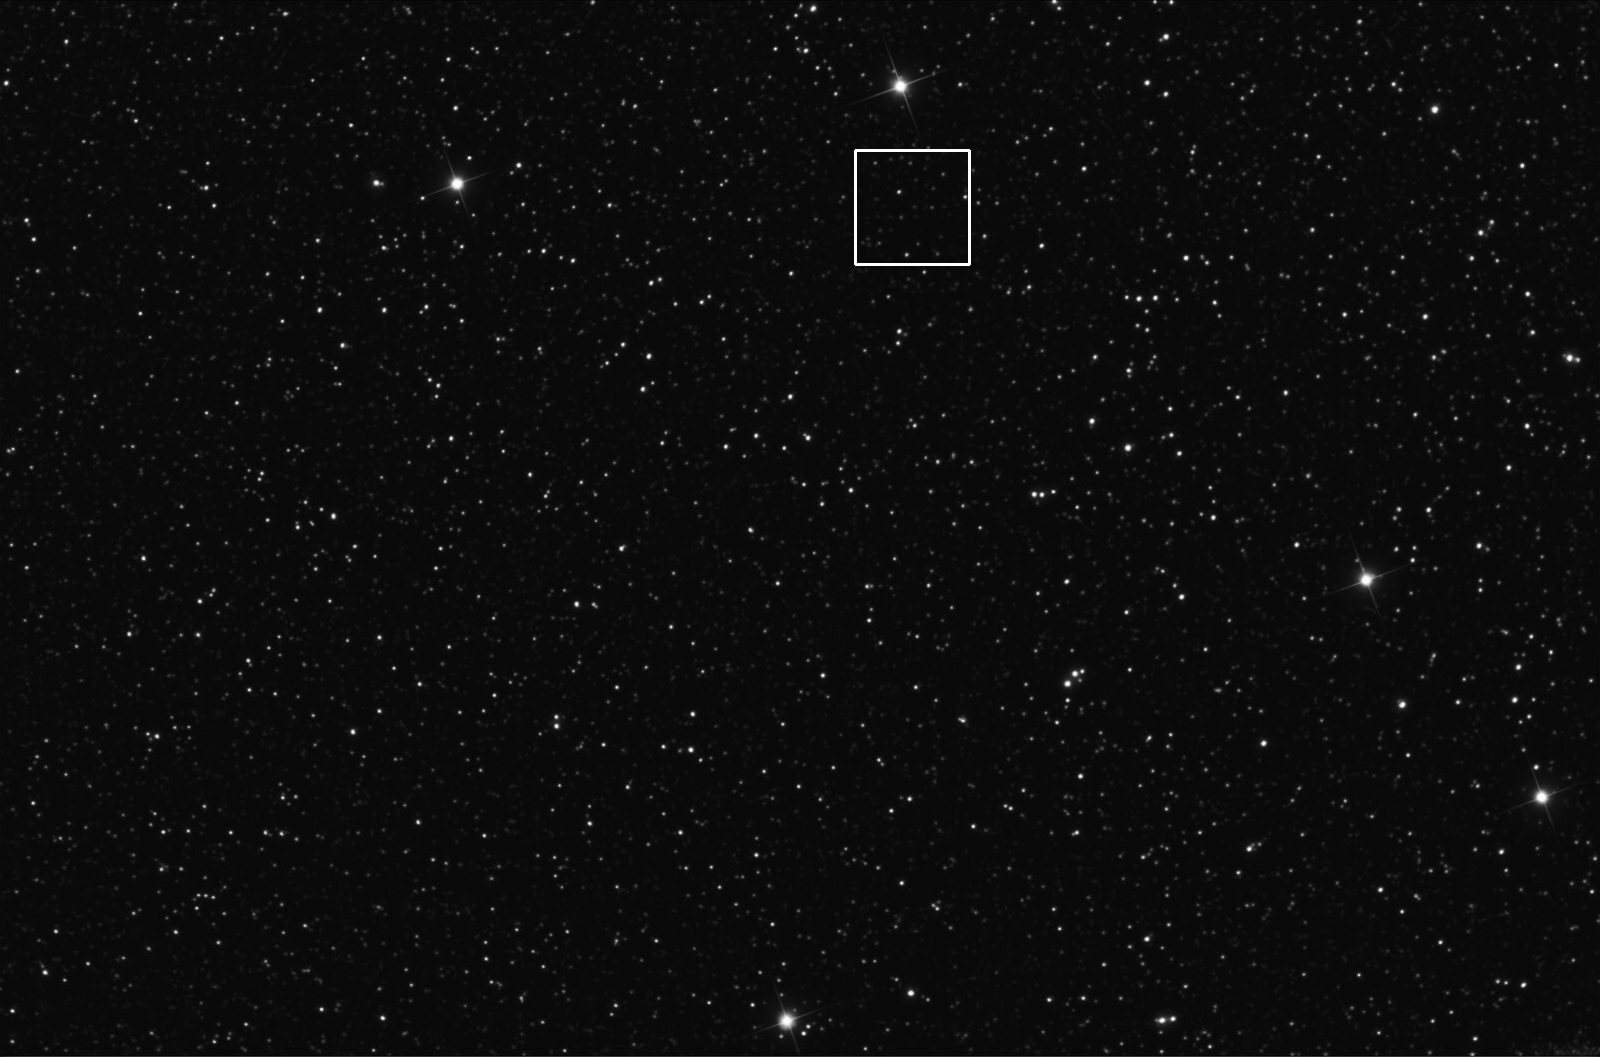

In [9]:
from google.colab.patches import cv2_imshow
print('method used: %s\ndegree interval: %s\nthreshold: %s' %(method_str, degree_interval, threshold))
method = eval(method_str)
display_img = img.copy()
for deg in range(0, 360, degree_interval):
  rotated_template = cv.imread(os.path.join(template_path, 'template%d.png' %deg), cv.IMREAD_GRAYSCALE)
  mask = cv.imread(os.path.join(masks_path, 'mask%d.png' %deg), cv.IMREAD_GRAYSCALE)
  if rotated_template is None or mask is None:
    print('Failed to load template/mask %d!' %deg)
  else:
    w, h = rotated_template.shape[::-1]
    result = cv.matchTemplate(display_img, rotated_template, method, mask=mask)

    loc = np.where(result < threshold)
    if len(loc) > 1:
      min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
      pt = min_loc
    else:
      for point in zip(*loc[::-1]):
        pt = point
        break
    if len(loc) != 0 and result[pt[1], pt[0]] < threshold:
      top_left = pt
      top_right = (pt[0] + w, pt[1])
      bottom_left = (pt[0], pt[1] + h)
      bottom_right = (pt[0] + w, pt[1] + h)

      cv.rectangle(display_img, pt, bottom_right, (255,0,0), 2)
      print('Match for deg{}, on {}, {}, {}, {} with {}'.format(deg,
                                                                top_left,
                                                                top_right,
                                                                bottom_left,
                                                                bottom_right,
                                                                result[pt[1],pt[0]]))
      break

cv.imwrite(os.path.join(results_path, 'result.jpg'), display_img)
cv2_imshow(template)
cv2_imshow(display_img)

